First part of the video talks about how derivatives work. Then we move on to Data Structures that are necessary.

In [1]:
import math

In [154]:
class Value:
    
    def __init__(self,data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda:None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data}, label={self.label})"
    
    def __add__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data + other.data, (self,other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __radd__(self,other):
        return self+other
    
    def __mul__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data * other.data, (self,other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self,other):
        return self*other
    
    def __pow__(self,other):
        assert isinstance(other, (int,float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'^{other}')

        def _backward():
            self.grad += other*(self.data**(other - 1)) * out.grad
        out._backward = _backward
        return out

    def __sub__(self, other):
        return self + (-1 * other)

    def __truediv__(self,other):
        return self * other**-1
    

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out    
    
    def tanh(self):
        n = self.data
        t = (math.exp(2*n) -1)/(math.exp(2*n) + 1)
        out = Value(t, (self,),'tanh')

        def _backward():
            self.grad += (1-t**2) * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
    
    def zero_grad(self):
        self.grad = 0.0
 



In [153]:
a.grad = 2.0
#a.zero_grad()
print(a.grad)

2.0


In [151]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
print(a)
print(a+b)
print(a*b)

Value(data=2.0, label=a)
Value(data=-1.0, label=)
Value(data=-6.0, label=)


In [4]:
e = a*b
e.label = 'e'
d = e+c
d.label = 'd'

f = Value(-2.0, label='f')
L = d*f
L.label = 'L'

In [5]:
print(d._prev)
print(d._op)

{Value(data=-6.0, label=e), Value(data=10.0, label=c)}
+


We use Graphviz to visualize the graph that we are creating

In [6]:
from graphviz import Digraph

def trace(root):

    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes,edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))

        dot.node(name =uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data,n.grad), shape='record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)
    
    for n1,n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

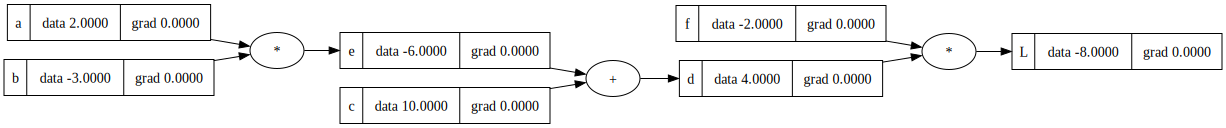

In [7]:
draw_dot(L)

In [29]:
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
w1 = Value(-3.0,label = 'w1')
w2 = Value(1.0,label = 'w2')
b = Value(6.8813735870195432,label = 'b')


x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = ' x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n' 
o = n.tanh(); o.label = 'output'

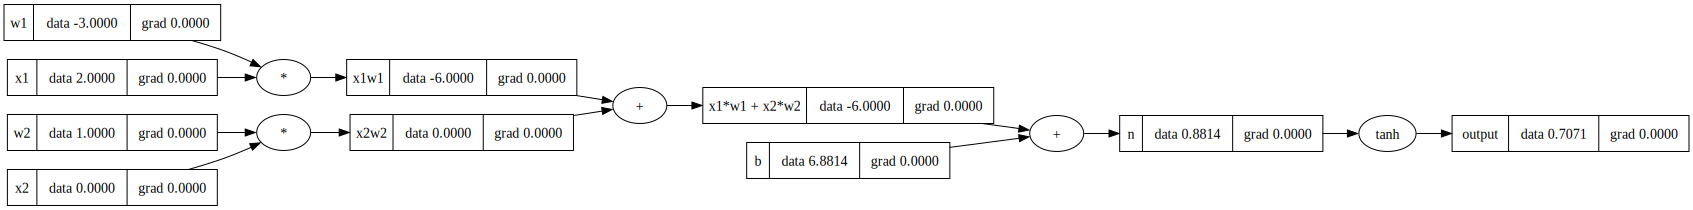

In [9]:
draw_dot(o)

Here is backpropogation completely done manually

In [10]:
o.grad = 1.0
n.grad = 1.0 - (o.data*o.data)
b.grad = n.grad
x1w1x2w2.grad = n.grad
x1w1.grad = x1w1x2w2.grad
x2w2.grad = x1w1x2w2.grad
w1.grad = x1.data * x1w1.grad
w2.grad = x2.data * x2w2.grad
# x1 and x2 are inputs so no need to backpropagate error to them

Here is backpropogation done semi-manually

In [11]:
o.grad = 1.0
o._backward()
n._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

Automated backpropagation

In [12]:
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

[Value(data=6.881373587019543, label=b),
 Value(data=0.0, label=x2),
 Value(data=1.0, label=w2),
 Value(data=0.0, label=x2w2),
 Value(data=-3.0, label=w1),
 Value(data=2.0, label=x1),
 Value(data=-6.0, label=x1w1),
 Value(data=-6.0, label= x1*w1 + x2*w2),
 Value(data=0.8813735870195432, label=n),
 Value(data=0.7071067811865476, label=output)]

In [13]:
o.grad = 1.0
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

for node in reversed(topo):
    node._backward()

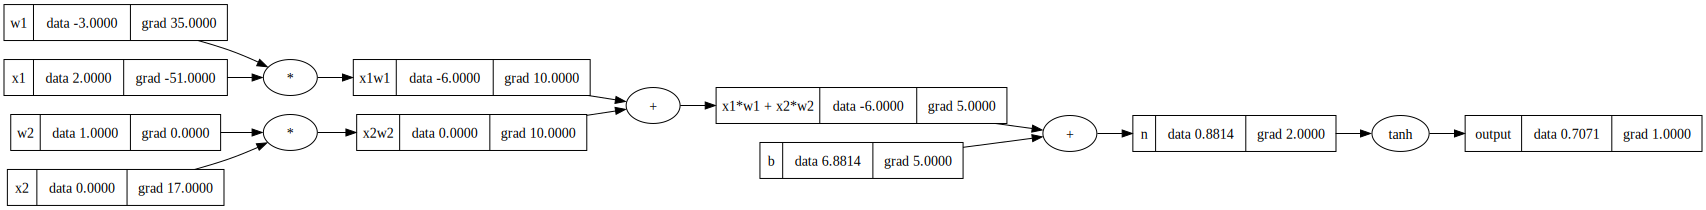

In [14]:
o.backward()
draw_dot(o)

bug fixing lol

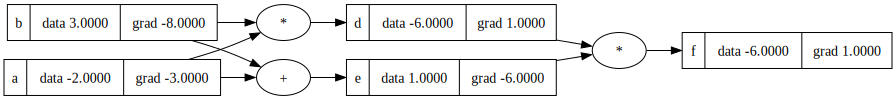

In [15]:
# do += in Value class

a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a*b ; d.label = 'd'
e = a+b ; e.label = 'e'
f = d*e ; f.label = 'f'

f.backward()

draw_dot(f)



Implementing tanh with its composite functions

In [50]:
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
w1 = Value(-3.0,label = 'w1')
w2 = Value(1.0,label = 'w2')
b = Value(6.8813735870195432,label = 'b')


x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = ' x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n' 
e = (2*n).exp(); e.label = 'e'
o = (e - 1)/(e + 1); o.label = 'output'

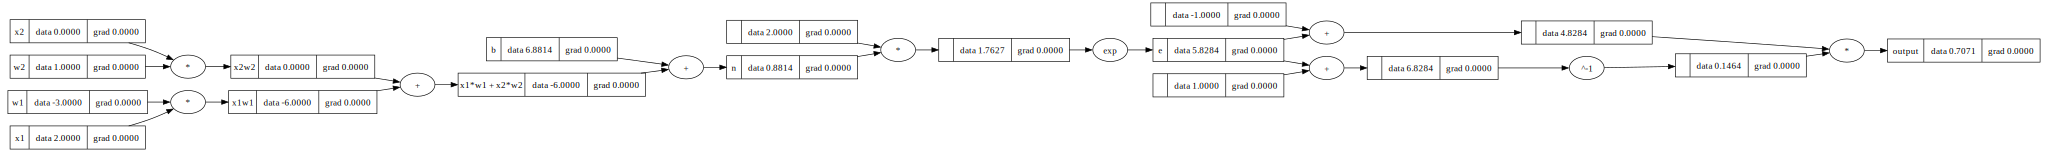

In [52]:
draw_dot(o)

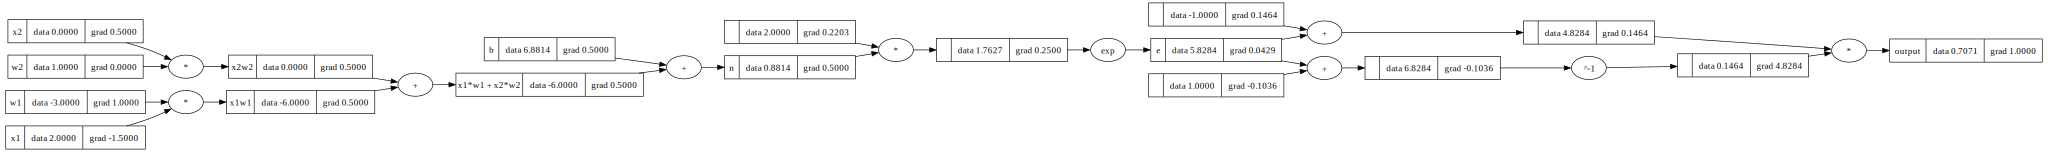

In [53]:
o.backward()
draw_dot(o)

# Neural Net Library

In [54]:
import random

In [155]:
class Neuron:

    def __init__(self,nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
    
    def __call__(self,x):
        act = sum((wi*xi for wi,xi in zip(self.w,x)),self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

In [156]:
class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self,x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]



In [157]:
class MLP:

    def __init__(self,nin,nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i],sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [76]:
x = [2.0,3.0]
n = Neuron(2)
n(x)

Value(data=-0.934429990444294, label=)

In [77]:
n = Layer(2,3)
n(x)

[Value(data=0.9902269372321195, label=),
 Value(data=-0.5672200135363116, label=),
 Value(data=-0.9294731211297567, label=)]

In [158]:
x = [2.0, 3.0, -1.0]
n = MLP(3,[4,4,1])
n(x)

Value(data=0.9516822178601997, label=)

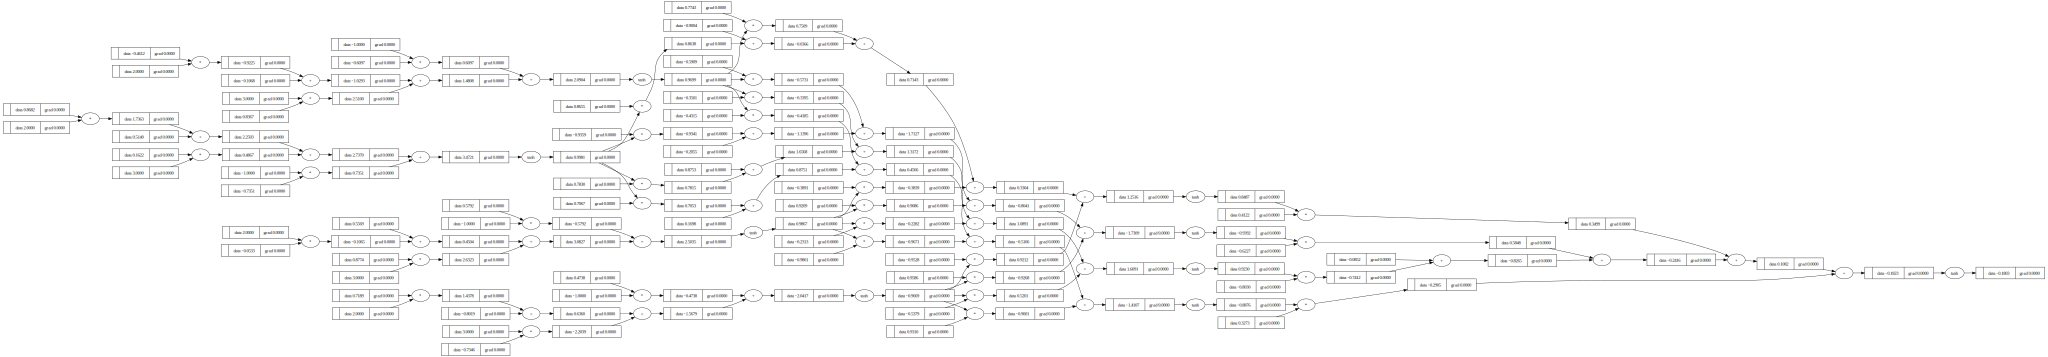

In [113]:
draw_dot(n(x))

Trying an example

In [171]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0,-1.0,-1.0,1.0]

In [172]:
n = MLP(3,[4,4,1])

In [115]:
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.18032046587434572, label=),
 Value(data=-0.7663510372783834, label=),
 Value(data=-0.8031536241910664, label=),
 Value(data=-0.1599213541842458, label=)]

Implementing Loss 

In [116]:
loss = sum([(yout-ygt)**2 for ygt,yout in zip(ys, ypred)])

In [117]:
loss

Value(data=2.8319142835044464, label=)

Gradient Descent

In [118]:
loss.backward()

In [119]:
n.layers[0].neurons[0].w[2].grad

0.1197573702063427

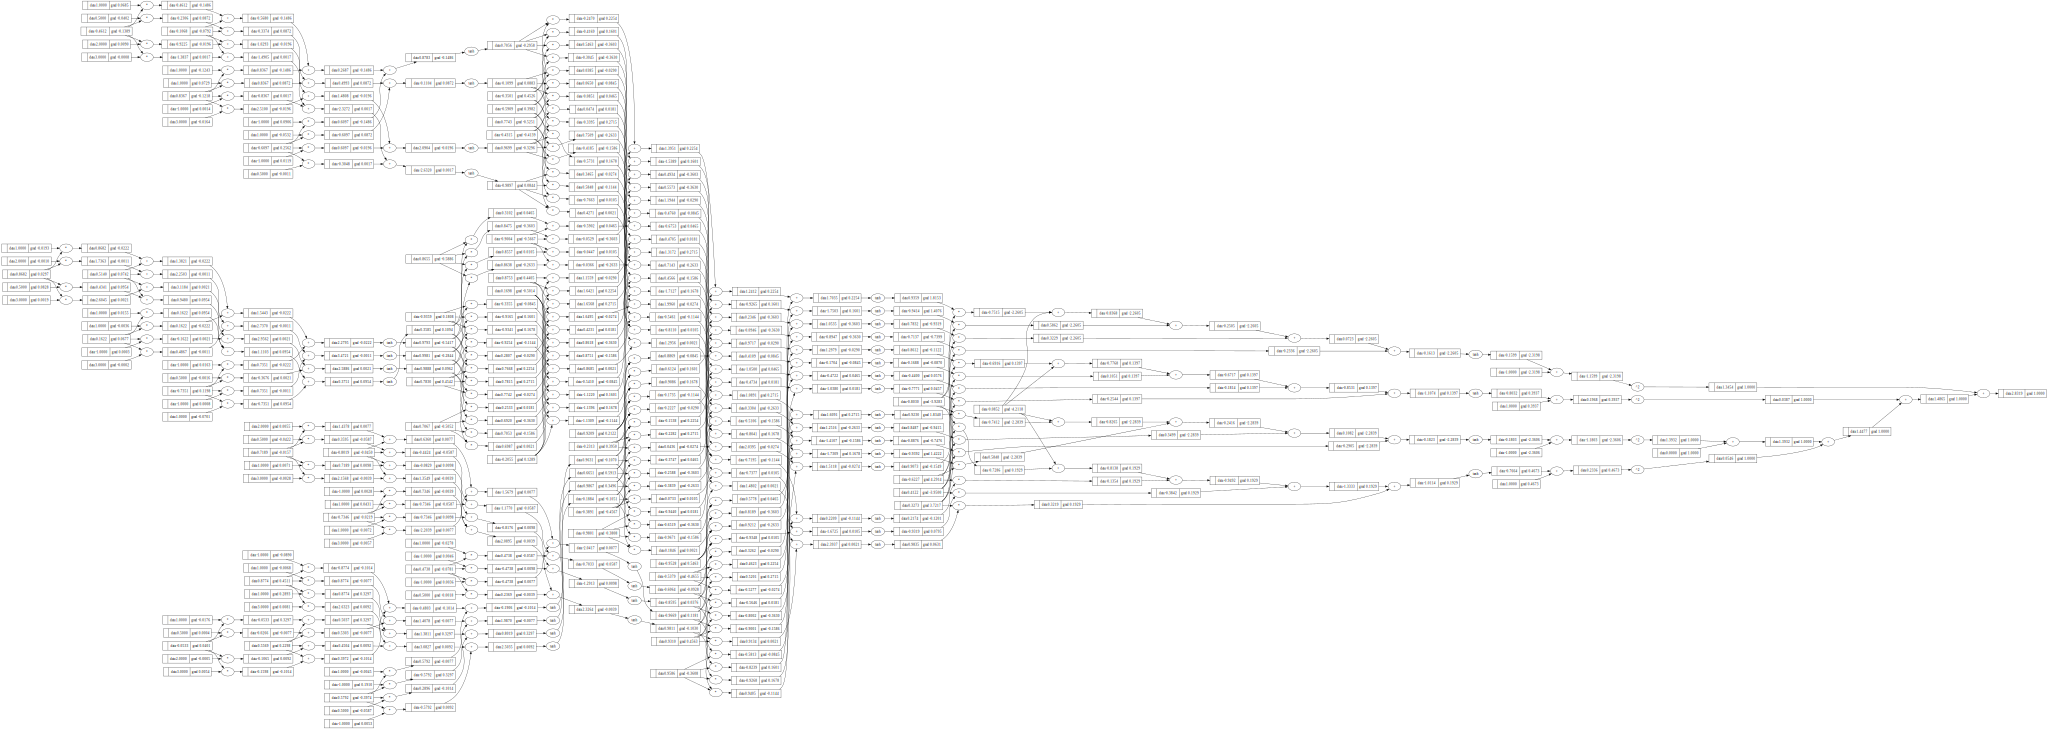

In [120]:
draw_dot(loss)

Now just keep doing the next 4 steps over and over again for gradient descent

In [137]:
for p in n.parameters():
    p.data += -0.01 * p.grad

In [138]:
ypred = [n(x) for x in xs]
ypred

[Value(data=0.9999600483896657, label=),
 Value(data=-0.9927636609774233, label=),
 Value(data=-0.9594170029112961, label=),
 Value(data=0.9999183505945534, label=)]

In [139]:
loss = sum([(yout-ygt)**2 for ygt,yout in zip(ys, ypred)])
loss

Value(data=0.001699352517907997, label=)

In [136]:
loss.backward()

Now, lets implement training loops

In [173]:
for k in range(1000):

    #forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt,yout in zip(ys,ypred))

    #backward pass
    for p in n.parameters():
        p.zero_grad()
    loss.backward()

    #update
    for p in n.parameters():
        p.data += -0.1 * p.grad
    
    print(f' step:{k} loss:{loss.data}')


 step:0 loss:4.140369761212305
 step:1 loss:3.3869064278281042
 step:2 loss:1.9343462010453294
 step:3 loss:2.156982722346916
 step:4 loss:0.1505772869239683
 step:5 loss:0.07913996669756627
 step:6 loss:0.058521688323777306
 step:7 loss:0.04749084811680851
 step:8 loss:0.04037238207109846
 step:9 loss:0.03530186363285549
 step:10 loss:0.0314613521199907
 step:11 loss:0.028428111730862005
 step:12 loss:0.025958672036849685
 step:13 loss:0.023901502273508127
 step:14 loss:0.022156620940312264
 step:15 loss:0.020654983869257945
 step:16 loss:0.019347138733662575
 step:17 loss:0.018196592156701753
 step:18 loss:0.017175736269571605
 step:19 loss:0.016263242421223498
 step:20 loss:0.01544233479045621
 step:21 loss:0.014699612383991964
 step:22 loss:0.014024224306572169
 step:23 loss:0.013407279256140403
 step:24 loss:0.012841414287027507
 step:25 loss:0.012320474318418954
 step:26 loss:0.011839270195074613
 step:27 loss:0.011393393466801327
 step:28 loss:0.010979072783766414
 step:29 loss:

In [174]:
ypred

[Value(data=0.9928512892984689, label=),
 Value(data=-0.9933963779692915, label=),
 Value(data=-0.9921649155538673, label=),
 Value(data=0.9905056527291629, label=)]

Predictions look good !